# LightGBM Classifier
**Example 4.0c, LightGBM classifier:** This trains a particle classifier using Random Forest distributed using PySpark ML APIs.

The High-Level Features classifier is built with labeled data
 - input: 14 features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)
![Physics use case for the particle classifier](../Docs/Physics_use_case.png)

To run this notebook we used the following configuration:

The notebook has been tested using the following configuration:
* *Software stack*: Spark 3.3.1, LightGBM and synapseml 0.10.2
* *Platform*: CentOS 7, Python 3.9
* *Spark cluster*: Analytix

In [ ]:
# No need to run this when using CERN SWAN service
# Just add the configuration parameters for Spark on the "star" button integration

# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-3.3.2-bin-hadoop3') #set path to SPARK_HOME

# Create Spark session and configure according to your environment
from pyspark.sql import SparkSession

spark = ( SparkSession.builder
          .appName("Training-LightGBM")
          .master("yarn")
          .config("spark.driver.memory","4g")
          .config("spark.executor.memory","32g")
          .config("spark.executor.cores","10")
          .config("spark.executor.instances","1")
          .config("spark.dynamicAllocation.enabled","false")
          .config("spark.sql.execution.arrow.pyspark.enabled", "true")
          .config("spark.sql.parquet.enableVectorizedReader", "false")
          .config("spark.ui.showConsoleProgress", "false")
          .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.10.2")
          .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")
          .getOrCreate()
        )

#          .config("spark.yarn.user.classpath.first", "true")


In [2]:
spark

## Load train and test dataframes

In [3]:
# For CERN users, data is available on the Analytix cluster
# You can also download the test and training data sets as described at
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
# DATASET_NAME="trainUndersampled.parquet"
# wget -r -np -R "index.html*" -e robots=off http://sparkdltrigger.web.cern.ch/sparkdltrigger/$DATASET_NAME
# ...

# For CERN users, data is already available on the Analytix Hadoop cluster
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"

trainDF = ( spark.read.format('parquet')
              .load(PATH + 'trainUndersampled.parquet')
              .selectExpr('hfeatures as features', 'label')
          )
        
testDF = ( spark.read.format('parquet')
             .load(PATH + 'testUndersampled.parquet')
             .selectExpr('hfeatures as features', 'label', 'encoded_label')
         )

In [4]:
# Optionally count the number of events in the training and test datasets
print('There are', trainDF.count(), 'training events')
print('There are', testDF.count(), 'test events')

There are 3426083 training events
There are 856090 test events


In [5]:
# There are 14 High Level Features for this classifier, 
# packed into a vector in the "features" column
# The label can take 3 possible values. Details at:
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data

trainDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)



In [6]:
testDF.show(3)

+--------------------+-----+-------------+
|            features|label|encoded_label|
+--------------------+-----+-------------+
|[74.9491729736328...|    0|(3,[0],[1.0])|
|[0.0,27.335390090...|    0|(3,[0],[1.0])|
|[47.6835403442382...|    0|(3,[0],[1.0])|
+--------------------+-----+-------------+
only showing top 3 rows



## Train the classifier using LightGBM

In [7]:
# requires lightGBM
# !pip install lightgbm
from synapse.ml.lightgbm import LightGBMClassifier

model = LightGBMClassifier(objective='multiclass')


In [8]:
%time gbm_model = model.fit(trainDF)

CPU times: user 36.7 ms, sys: 22.7 ms, total: 59.4 ms
Wall time: 1min 30s


## Save the model

In [ ]:
# save the model to the local filesystem
gbm_model.save(path='file:/tmp/models/GBM/gbm_model')

## Prediction

In [9]:
pred = gbm_model.transform(testDF)

In [10]:
pred.show(5)

23/02/24 15:53:52 WARN DAGScheduler: Broadcasting large task binary with size 1099.4 KiB


+--------------------+-----+-------------+--------------------+--------------------+----------+
|            features|label|encoded_label|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+--------------------+----------+
|[74.9491729736328...|    0|(3,[0],[1.0])|[1.80693299538203...|[0.99104608682686...|       0.0|
|[0.0,27.335390090...|    0|(3,[0],[1.0])|[0.55580234897910...|[0.88318448913853...|       0.0|
|[47.6835403442382...|    0|(3,[0],[1.0])|[1.16190661904102...|[0.96812987091222...|       0.0|
|[80.9036312103271...|    0|(3,[0],[1.0])|[1.22871101434430...|[0.92824126453611...|       0.0|
|[95.2762756347656...|    0|(3,[0],[1.0])|[-0.0258602123350...|[0.88969609154375...|       0.0|
+--------------------+-----+-------------+--------------------+--------------------+----------+
only showing top 5 rows



## Compute the AUC

In [11]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('probability').alias('probability')])

In [12]:
%time pred_pd = pred.select(['encoded_label', 'probability']).toPandas()

23/02/24 15:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1086.8 KiB


CPU times: user 776 ms, sys: 294 ms, total: 1.07 s
Wall time: 59.3 s


In [13]:
pred_pd.head()

,encoded_label,probability
0,"[1.0, 0.0, 0.0]","[0.9910460868268698, 0.0023829251567053502, 0...."
1,"[1.0, 0.0, 0.0]","[0.8831844891385315, 0.005853727003600766, 0.1..."
2,"[1.0, 0.0, 0.0]","[0.9681298709122245, 0.008860690795284882, 0.0..."
3,"[1.0, 0.0, 0.0]","[0.9282412645361183, 0.015820103532417293, 0.0..."
4,"[1.0, 0.0, 0.0]","[0.8896960915437561, 0.09051627405878927, 0.01..."


In [14]:
import numpy as np
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['probability'].tolist())

In [15]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


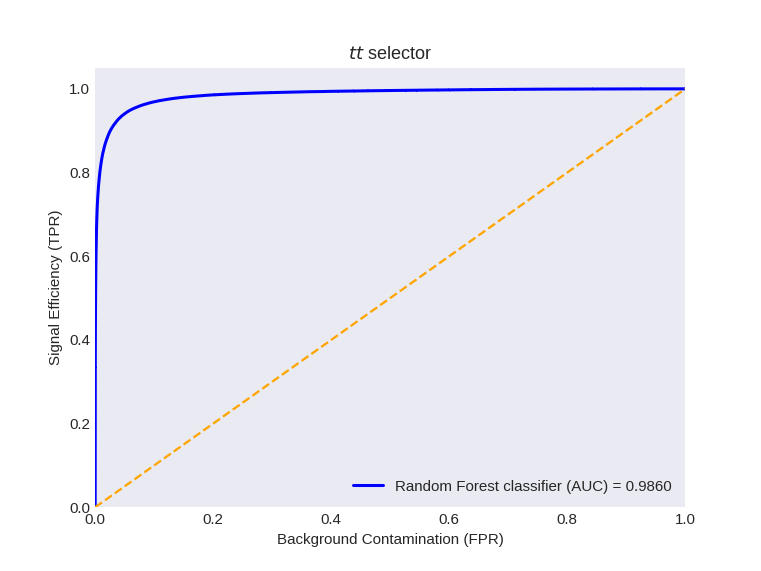

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


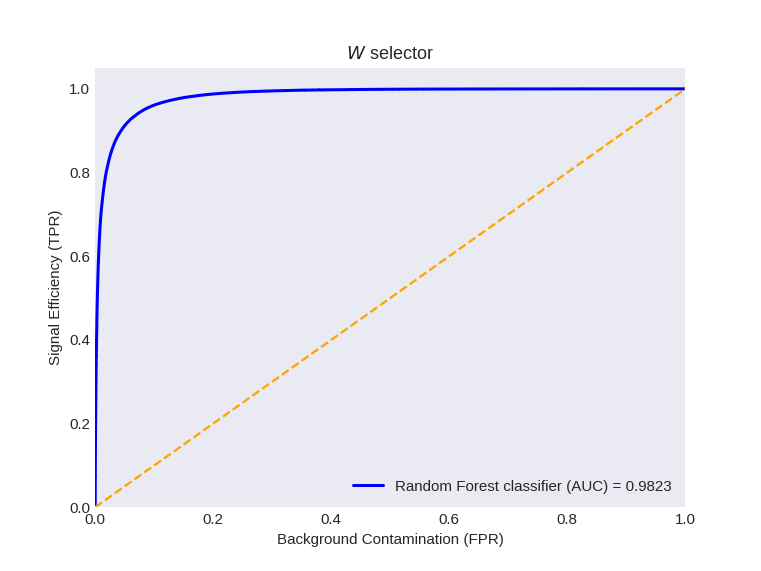

In [17]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Confusion Matrix

In [18]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9186


/tmp/luca/ipykernel_30934/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


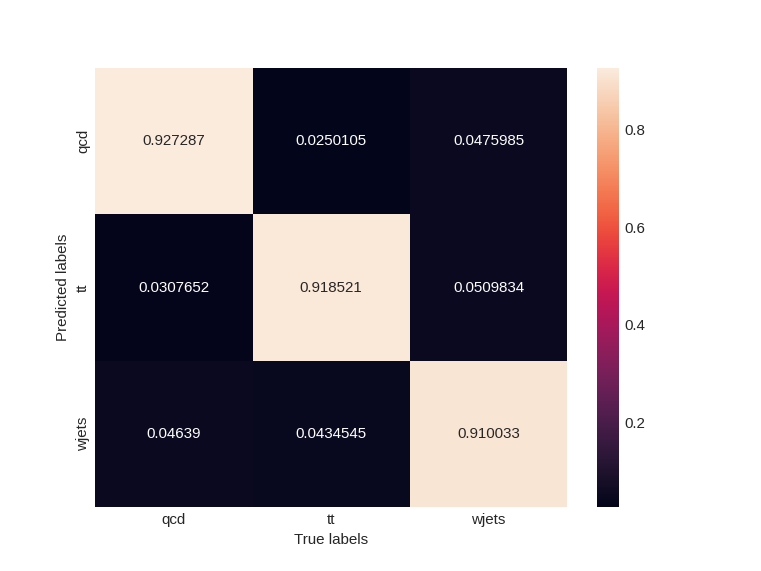

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [20]:
spark.stop()